In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from numpy.linalg import matrix_rank
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

# Data preparation and functions

In [2]:
data = pd.read_csv('jpn_macro.csv')
data = data.rename(columns={'Unnamed: 0': "dates"})
data['dates'] = data['dates'].astype(str)
data['dates'] = pd.to_datetime(data['dates'], format='%Y.%m')
data = data.set_index('dates')
data = data.transform(lambda x : (x-np.mean(x)))

In [28]:
def PLS_univarie(X,Y):
    
    X = np.array(X)
    Y = np.array(Y)
    Y = Y.reshape((-1,1))
    
    Xs = []
    Xs.append(X)
    
    Ys = []
    Ys.append(Y)

    observations, variables = X.shape
    r = matrix_rank(X)
    
    W = np.zeros((variables,r))
    Z = np.zeros((observations,r))
    P = np.zeros((variables,r))
    D = np.zeros((r))
    
    for i in range(r+1):
        x = Xs[-1]
        y = Ys[-1]
        
        w = (X.T@y)@inv(y.T@y)
        w = w@inv(np.sqrt(w.T@w))

        z = (X@w)@inv(w.T@w)
        
        p = (X.T@z)@inv(z.T@z)
        
        X1 = X - z@p.T
        
        d = (y.T@z)@inv(z.T@z)

        Y1 = y - d*z

        
        Xs.append(X1)
        Ys.append(Y1)
        
        w = w.flatten()
        z = z.flatten()
        p = p.flatten()
        d = d.flatten()
        
        W[:,i-1] = w
        Z[:,i-1] = z
        P[:,i-1] = p
        D[i-1] = d
        
        
    return Xs, Ys, W, Z, P, D

def bic(n, k, rss):
    """
    Calculate the Bayesian Information Criterion (BIC).

    Parameters:
    - n: Number of observations
    - k: Number of parameters in the model
    - rss: Residual sum of squares

    Returns:
    - BIC value
    """
    return n * np.log(rss / n) + k * np.log(n)

def pls_nipals(X, Y, n_components, max_iter):
    
    X = np.array(X)
    Y = np.array(Y)
    
    T = np.zeros((X.shape[0], n_components))
    P = np.zeros((X.shape[1], n_components))
    U = np.zeros((Y.shape[0], n_components))
    Q = np.zeros((Y.shape[1], n_components))
    W = np.zeros((X.shape[1], n_components))
    B = np.zeros((n_components, Y.shape[1]))

    for i in range(n_components):
        u = Y[:, 0]

        for j in range(max_iter):
            w = X.T @ u
            w /= np.linalg.norm(w)
            t = X @ w
            c = Y.T @ t
            c /= np.linalg.norm(c)
            u_new = Y @ c

            if np.linalg.norm(u_new - u) < 1e-10:
                break

            u = u_new

        p = X.T @ t / (t.T @ t)
        q = Y.T @ t / (t.T @ t)
        W[:, i] = w.flatten()
        T[:, i] = t.flatten()
        P[:, i] = p.flatten()
        U[:, i] = u.flatten()
        Q[:, i] = q.flatten()

        B[i, :] = (t.T @ Y) / (t.T @ t)

        X -= np.outer(t, p)
        Y -= np.outer(t, q)

    B_pls = W @ np.linalg.inv(P.T @ W) @ B

    return T, P, U, Q, W, B_pls, Y


def rolling_window(data, targets, max_components, window_size, max_iter, forecast_horizon):
    forecasts = []
    optimal_components_list = []
    total_windows = len(data) - window_size - forecast_horizon + 1

    for start in range(total_windows):
        end = start + window_size
        training_data = data.iloc[start:end]
        test_data = data.iloc[end:end + forecast_horizon]

        Y_train = training_data[targets].values
        X_train = training_data.drop(targets, axis=1).values
        X_test = test_data.drop(targets, axis=1).values

        min_bic = np.inf
        best_B_pls = None
        optimal_components = 0
        n_observations = len(Y_train)

        for n_components in range(1, max_components + 1):
            _, _, _, _, _, B_pls, _ = pls_nipals(X_train, Y_train, n_components, max_iter)
            Y_pred = X_train @ B_pls
            rss = np.sum((Y_train - Y_pred) ** 2)
            bic_value = bic(n_observations, n_components, rss)

            if bic_value < min_bic:
                min_bic = bic_value
                best_B_pls = B_pls
                optimal_components = n_components

        Y_forecast = X_test @ best_B_pls

        if Y_forecast.shape[0] >= forecast_horizon:
            forecasts.append(Y_forecast[-1])  # Append only the h-th step forecast
        optimal_components_list.append(optimal_components)

    return np.array(forecasts), optimal_components_list
        
def R_carré(Y, Y_hat):
    
    ss_res = np.sum((Y - Y_hat) ** 2)
    ss_tot = np.sum((Y - np.mean(Y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared

# Univariate model

In [5]:
X = data.drop(['x2'], axis = 1)
Y = data[['x2']]

T, P, U, Q, W, B_pls, Y_pls = pls_nipals(X, Y,218,50)

In [6]:
print(np.argsort(-np.abs(W[:,0]))[:5],
np.argsort(-np.abs(W[:,1]))[:5],
np.argsort(-np.abs(W[:,2]))[:5])

[ 31   7 140 143  38] [ 93  85  84 152  83] [ 93 183 184 134 135]


In [7]:
Y_hat = pd.DataFrame(X@B_pls)
Y_hat.columns = ['x2 fitted']

Y_hat = Y_hat.set_index(Y.index)
Y_hat.index = pd.to_datetime(Y_hat.index)

Y_final = pd.concat([Y_hat, Y], axis=1)


R_carré(Y,np.array(X@B_pls))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


x2    0.997787
dtype: float64

# Comparison with scikit

In [8]:
pls = PLSRegression(n_components=128) 
pls.fit(X, Y)
x_weights_ = pls.x_weights_

In [9]:
print(np.argsort(-np.abs(x_weights_[:,0]))[:5],
np.argsort(-np.abs(x_weights_[:,1]))[:5],
np.argsort(-np.abs(x_weights_[:,2]))[:5])

[ 0 17 25 18 19] [63 61 51  0 50] [133 129 131 132 130]


# Bivariate model

In [10]:
X = data.drop(['x2','x106'], axis = 1)
Y = data[['x2','x106']]

T, P, U, Q, W, B_pls, Y_pls = pls_nipals(X, Y,217,50)

In [11]:
print(np.argsort(-np.abs(W[:,0]))[:5],
np.argsort(-np.abs(W[:,1]))[:5],
np.argsort(-np.abs(W[:,2]))[:5])

[ 31   7 139  93 142] [ 93 183 182 124 125] [107 105  93 109  85]


In [12]:
Y_hat = pd.DataFrame(X@B_pls)
Y_hat.columns = ['x2 fitted','x106 fitted']

Y_hat = Y_hat.set_index(Y.index)
Y_hat.index = pd.to_datetime(Y_hat.index)

Y_final = pd.concat([Y_hat, Y], axis=1)


(R_carré(Y['x2'],Y_final['x2 fitted']),R_carré(Y['x106'],Y_final['x106 fitted']))

(0.9977656423527695, 0.8356243688823778)

# Comparison with scikit

In [13]:
pls = PLSRegression(n_components=127) 
pls.fit(X, Y)
x_weights_ = pls.x_weights_

In [14]:
print(np.argsort(-np.abs(x_weights_[:,0]))[:5],
np.argsort(-np.abs(x_weights_[:,1]))[:5],
np.argsort(-np.abs(x_weights_[:,2]))[:5])

[ 0 17 22 25 18] [107 105 104 109 106] [107 105 109 130 131]


# Forecasting exercise 

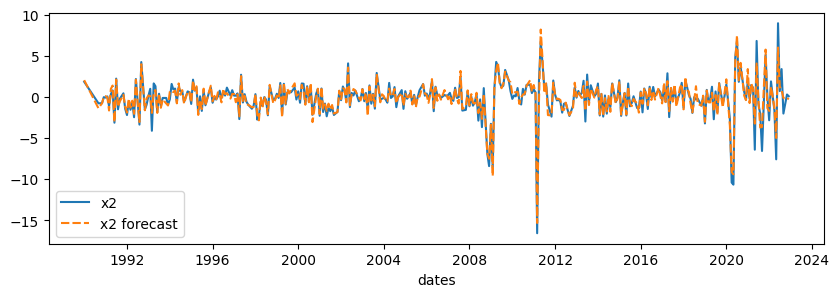

0.3989667643812214


In [29]:
X = data.drop(['x2'], axis = 1)
Y = data[['x2']]

forecasts, _ = rolling_window(data, ['x2'], 10, 200, 50, 1)

Y_hat = pd.DataFrame(forecasts)
Y_hat.columns = ['x2 forecast']

Y_fin = Y.tail(len(Y_hat))
Y_hat = Y_hat.set_index(Y_fin.index)
Y_hat.index = pd.to_datetime(Y_hat.index)

Y_final = pd.concat([Y_hat, Y_fin], axis=1)


fig, axes = plt.subplots(figsize=(10, 3))
sns.lineplot(data=Y_final[['x2', 'x2 forecast']], ax=axes, errorbar=None)
plt.show()

print((np.mean((Y_final['x2'] - Y_final['x2 forecast'])**2)))

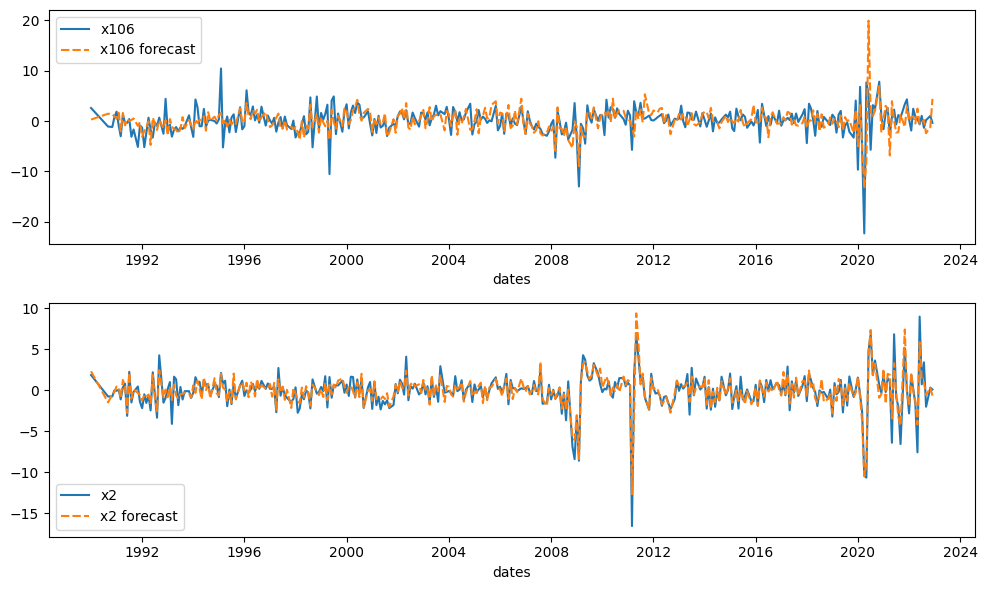

(0.8061374125565722, 5.526052688920195)


In [30]:
X = data.drop(['x2','x106'], axis = 1)
Y = data[['x2','x106']]

forecasts, _ = rolling_window(data, ['x2','x106'], 10, 200, 50, 1)

Y_hat = pd.DataFrame(forecasts)
Y_hat.columns = ['x2 forecast','x106 forecast']

Y_fin = Y.tail(len(Y_hat))
Y_hat = Y_hat.set_index(Y_fin.index)
Y_hat.index = pd.to_datetime(Y_hat.index)

Y_final = pd.concat([Y_hat, Y_fin], axis=1)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))  # 2 Rows, 1 Column

# Plot for 'x106' and 'x106 forecast'
sns.lineplot(data=Y_final[['x106', 'x106 forecast']], ax=axes[0], errorbar=None)

# Plot for 'x2' and 'x2 forecast'
sns.lineplot(data=Y_final[['x2', 'x2 forecast']], ax=axes[1], errorbar=None)

plt.tight_layout()
plt.show()

print((np.mean((Y_final['x2'] - Y_final['x2 forecast'])**2),np.mean((Y_final['x106'] - Y_final['x106 forecast'])**2)))

# Comparison with sci kit PLS function

In [31]:
def rolling_window(data, targets, max_components, window_size, max_iter, forecast_horizon):
    forecasts = []
    optimal_components_list = []
    total_windows = len(data) - window_size - forecast_horizon + 1

    for start in range(total_windows):
        end = start + window_size
        training_data = data.iloc[start:end]
        test_data = data.iloc[end:end + forecast_horizon]

        Y_train = training_data[targets].values
        X_train = training_data.drop(targets, axis=1).values
        X_test = test_data.drop(targets, axis=1).values

        min_bic = np.inf
        best_B_pls = None
        optimal_components = 0
        n_observations = len(Y_train)

        for n_components in range(1, max_components + 1):
            pls = PLSRegression(n_components=n_components) 
            pls.fit(X_train, Y_train)
            coef_ = pls.coef_

            Y_pred = pls.predict(X_train)
            rss = np.sum((Y_train - Y_pred) ** 2)
            bic_value = bic(n_observations, n_components, rss)

            if bic_value < min_bic:
                min_bic = bic_value
                best_B_pls = coef_
                optimal_components = n_components

        Y_forecast = X_test @ best_B_pls.T

        if Y_forecast.shape[0] >= forecast_horizon:
            forecasts.append(Y_forecast[-1])  # Append only the h-th step forecast
        optimal_components_list.append(optimal_components)

    return np.array(forecasts), optimal_components_list

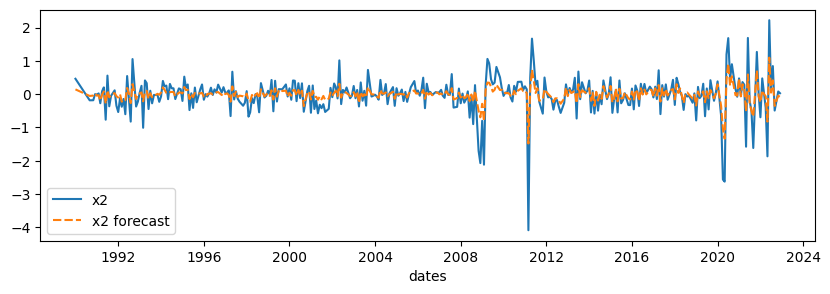

0.12067056040107137


In [32]:
data = pd.read_csv('jpn_macro.csv')
data = data.rename(columns={'Unnamed: 0': "dates"})
data['dates'] = data['dates'].astype(str)
data['dates'] = pd.to_datetime(data['dates'], format='%Y.%m')
data = data.set_index('dates')
data = data.transform(lambda x : (x-np.mean(x))/np.var(x))


X = data.drop(['x2'], axis = 1)
Y = data[['x2']]

forecasts, _ = rolling_window(data, ['x2'], 10, 200, 50, 1)

Y_hat = pd.DataFrame(forecasts)
Y_hat.columns = ['x2 forecast']

Y_fin = Y.tail(len(Y_hat))
Y_hat = Y_hat.set_index(Y_fin.index)
Y_hat.index = pd.to_datetime(Y_hat.index)

Y_final = pd.concat([Y_hat, Y_fin], axis=1)


fig, axes = plt.subplots(figsize=(10, 3))
sns.lineplot(data=Y_final[['x2', 'x2 forecast']], ax=axes, errorbar=None)
plt.show()

print((np.mean((Y_final['x2'] - Y_final['x2 forecast'])**2)))

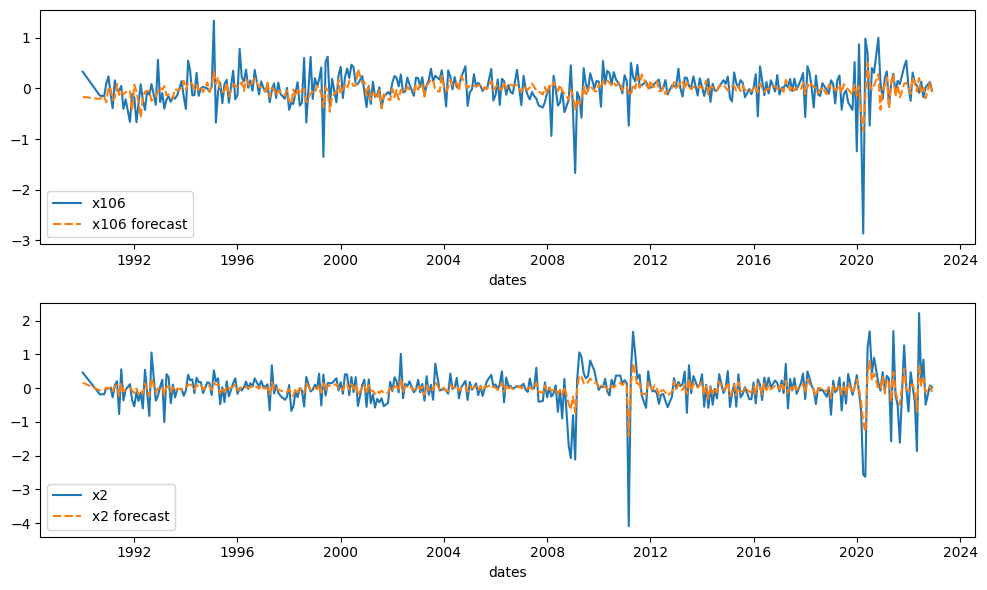

(0.13632932770455963, 0.09566081252263489)


In [33]:
X = data.drop(['x2','x106'], axis = 1)
Y = data[['x2','x106']]

forecasts, _ = rolling_window(data, ['x2','x106'], 10, 200, 50, 1)

Y_hat = pd.DataFrame(forecasts)
Y_hat.columns = ['x2 forecast','x106 forecast']

Y_fin = Y.tail(len(Y_hat))
Y_hat = Y_hat.set_index(Y_fin.index)
Y_hat.index = pd.to_datetime(Y_hat.index)

Y_final = pd.concat([Y_hat, Y_fin], axis=1)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(data=Y_final[['x106', 'x106 forecast']], ax=axes[0], errorbar=None)

sns.lineplot(data=Y_final[['x2', 'x2 forecast']], ax=axes[1], errorbar=None)

plt.tight_layout()
plt.show()

print((np.mean((Y_final['x2'] - Y_final['x2 forecast'])**2),np.mean((Y_final['x106'] - Y_final['x106 forecast'])**2)))